<a href="https://colab.research.google.com/github/Xavierree/Data-Analitic/blob/Efficient_net/1_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision opencv-python-headless "numpy<2.0" pandas matplotlib albumentations tqdm scikit-learn torchmetrics

In [ ]:
# Instalasi dependensi dari requirements.txt

# Impor pustaka dasar yang akan digunakan di beberapa sel
import os
import torch
import shutil
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import albumentations as A
from xml.etree import ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# --- 1. Instalasi dan Impor Library Awal ---
!pip install -q gdown

import os
import shutil
import zipfile
import gdown
from sklearn.model_selection import train_test_split

# --- 2. Konfigurasi Download (Bagian yang Perlu Diedit) ---
FILE_ID = "1sky3FSRpfCbsBWQ_EtyTMZt1DipOsLm1"
EXTRACTED_FOLDER_NAME = "Gabungan"

# --- 3. Proses Download dan Ekstrak ---
ZIP_FILE = "dataset.zip"
print(f"📥 Mengunduh dataset dari Google Drive (ID: {FILE_ID})...")
gdown.download(id=FILE_ID, output=ZIP_FILE, quiet=False)

print(f"\n✨ Unduhan selesai. Mengekstrak file '{ZIP_FILE}'...")
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(".")
print("✅ Ekstraksi selesai.")

# --- 4. Konfigurasi Path dan Pemisahan Data ---
DATASET_DIR = EXTRACTED_FOLDER_NAME
IMAGE_DIR_NAME = "Image"
ANNOT_DIR_NAME = "Annotation"
OUTPUT_DIR = "data_split"
TRAIN_RATIO = 0.8

IMAGE_DIR = os.path.join(DATASET_DIR, IMAGE_DIR_NAME)
ANNOT_DIR = os.path.join(DATASET_DIR, ANNOT_DIR_NAME)

print(f"\n📂 Mengecek direktori sumber di: {DATASET_DIR}")

if os.path.exists(IMAGE_DIR) and os.path.exists(ANNOT_DIR):
    print("👍 Direktori 'Image' dan 'Annotation' ditemukan. Memulai proses...")

    TRAIN_IMG_DIR = os.path.join(OUTPUT_DIR, "train", "Image")
    TRAIN_ANNOT_DIR = os.path.join(OUTPUT_DIR, "train", "Annotation")
    VAL_IMG_DIR = os.path.join(OUTPUT_DIR, "val", "Image")
    VAL_ANNOT_DIR = os.path.join(OUTPUT_DIR, "val", "Annotation")

    os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
    os.makedirs(TRAIN_ANNOT_DIR, exist_ok=True)
    os.makedirs(VAL_IMG_DIR, exist_ok=True)
    os.makedirs(VAL_ANNOT_DIR, exist_ok=True)

    image_filenames = [f for f in os.listdir(IMAGE_DIR) if f.endswith((".jpg", ".png", ".jpeg"))]
    train_images, val_images = train_test_split(image_filenames, train_size=TRAIN_RATIO, random_state=42)

    def copy_files(file_list, src_img, src_annot, dst_img, dst_annot):
        copied_count = 0
        for filename in file_list:
            annot_filename = os.path.splitext(filename)[0] + ".xml"
            src_annot_path = os.path.join(src_annot, annot_filename)

            if os.path.exists(src_annot_path):
                shutil.copy(os.path.join(src_img, filename), os.path.join(dst_img, filename))
                shutil.copy(src_annot_path, os.path.join(dst_annot, annot_filename))
                copied_count += 1
            else:
                print(f"⚠️ Peringatan: Anotasi '{annot_filename}' tidak ditemukan, gambar '{filename}' dilewati.")
        return copied_count

    print("\n⚙️ Memproses data latih...")
    num_train = copy_files(train_images, IMAGE_DIR, ANNOT_DIR, TRAIN_IMG_DIR, TRAIN_ANNOT_DIR)

    print("\n⚙️ Memproses data validasi...")
    num_val = copy_files(val_images, IMAGE_DIR, ANNOT_DIR, VAL_IMG_DIR, VAL_ANNOT_DIR)

    print("\n--- Ringkasan ---")
    print(f"Total gambar latih: {num_train}")
    print(f"Total gambar validasi: {num_val}")
    print(f"\n✅ Pemisahan data selesai. Data disimpan di folder: '{OUTPUT_DIR}'")
else:
    print(f"❌ Direktori data sumber tidak ditemukan di '{IMAGE_DIR}' atau '{ANNOT_DIR}'.")

📥 Mengunduh dataset dari Google Drive (ID: 1sky3FSRpfCbsBWQ_EtyTMZt1DipOsLm1)...


Downloading...
From (original): https://drive.google.com/uc?id=1sky3FSRpfCbsBWQ_EtyTMZt1DipOsLm1
From (redirected): https://drive.google.com/uc?id=1sky3FSRpfCbsBWQ_EtyTMZt1DipOsLm1&confirm=t&uuid=215a401a-20a8-45ca-bac7-bfe048d3b9be
To: /content/dataset.zip
100%|██████████| 57.1M/57.1M [00:00<00:00, 106MB/s]



✨ Unduhan selesai. Mengekstrak file 'dataset.zip'...
✅ Ekstraksi selesai.

📂 Mengecek direktori sumber di: Gabungan
👍 Direktori 'Image' dan 'Annotation' ditemukan. Memulai proses...

⚙️ Memproses data latih...
⚠️ Peringatan: Anotasi 'immature-107_jpg.rf.e6c1dbeaacc81094cc0c733ccf439233(1).xml' tidak ditemukan, gambar 'immature-107_jpg.rf.e6c1dbeaacc81094cc0c733ccf439233(1).jpg' dilewati.

⚙️ Memproses data validasi...

--- Ringkasan ---
Total gambar latih: 1295
Total gambar validasi: 325

✅ Pemisahan data selesai. Data disimpan di folder: 'data_split'


In [ ]:
# --- Impor Library untuk Konfigurasi ---
import torch
import os

# --- Konfigurasi Parameter Training ---
BATCH_SIZE = 8
RESIZE_TO = 640
NUM_EPOCHS = 20
# Untuk Colab, disarankan menggunakan 2 workers untuk menghindari potensi error
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# --- Konfigurasi Path Data ---
# Path ini sudah benar menunjuk ke folder 'data_split' yang dibuat oleh sel sebelumnya.
TRAIN_IMG = 'data_split/train/Image'
TRAIN_ANNOT = 'data_split/train/Annotation'
VALID_IMG = 'data_split/val/Image'
VALID_ANNOT = 'data_split/val/Annotation'

# --- Konfigurasi Kelas dan Direktori Output ---
CLASSES = ['__background__', 'Immature', 'Mature', 'Normal']
NUM_CLASSES = len(CLASSES)
OUT_DIR = 'outputs'

# Membuat direktori output jika belum ada
os.makedirs(OUT_DIR, exist_ok=True)

# --- Verifikasi Konfigurasi ---
print(f"Konfigurasi dimuat.")
print("--------------------")
print(f"Device yang digunakan: {DEVICE}")
print(f"Jumlah Epoch: {NUM_EPOCHS}")
print(f"Ukuran Batch: {BATCH_SIZE}")
print(f"Jumlah Kelas: {NUM_CLASSES} -> {CLASSES}")
print(f"Output akan disimpan di: {OUT_DIR}")
print(f"Path data latih: {TRAIN_IMG}")
print(f"Path data validasi: {VALID_IMG}")

Konfigurasi dimuat.
--------------------
Device yang digunakan: cuda
Jumlah Epoch: 20
Ukuran Batch: 8
Jumlah Kelas: 4 -> ['__background__', 'Immature', 'Mature', 'Normal']
Output akan disimpan di: outputs
Path data latih: data_split/train/Image
Path data validasi: data_split/val/Image


In [ ]:
# --- Cell 4: custom_utils.py ---

class Averager:
    def __init__(self): self.reset()
    def send(self, value): self.current_total += value; self.iterations += 1
    @property
    def value(self): return self.current_total / self.iterations if self.iterations > 0 else 0
    def reset(self): self.current_total = 0.0; self.iterations = 0.0

class SaveBestModel:
    def __init__(self, best_valid_map=0.0): self.best_valid_map = best_valid_map
    def __call__(self, model, current_valid_map, epoch, out_dir):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            file_name = f"{out_dir}/best_model_mAP_{current_valid_map:.4f}.pth"
            print(f"\nValid mAP meningkat. Menyimpan model ke {file_name}")
            torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict()}, file_name)

def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.3), A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def save_loss_plot(out_dir, train_loss_list):
    plt.figure(figsize=(10, 7)); plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title("Training Loss Plot"); plt.legend()
    plt.savefig(f"{out_dir}/train_loss.png"); plt.close()

def save_mAP(out_dir, map_50_list, map_95_list):
    plt.figure(figsize=(10, 7)); plt.plot(map_50_list, label='mAP@0.5', color='orange')
    plt.plot(map_95_list, label='mAP@0.5:0.95', color='red'); plt.xlabel('Epochs')
    plt.ylabel('mAP'); plt.title('mAP Over Epochs'); plt.legend()
    plt.savefig(f"{out_dir}/map_plot.png"); plt.close()

print("✅ Fungsi utilitas ('custom_utils.py') berhasil didefinisikan.")

✅ Fungsi utilitas ('custom_utils.py') berhasil didefinisikan.


In [ ]:
# --- Cell 5: datasets.py ---

class CustomDataset(Dataset):
    def __init__(self, img_path, annot_path, width, height, classes, transforms=None):
        self.img_path, self.annot_path = img_path, annot_path
        self.width, self.height = width, height
        self.classes, self.transforms = classes, transforms
        self.all_images = sorted(glob.glob(os.path.join(img_path, "*.jpg")))
    def __len__(self): return len(self.all_images)
    def __getitem__(self, idx):
        image_name = os.path.basename(self.all_images[idx])
        annot_path = os.path.join(self.annot_path, image_name.replace('.jpg', '.xml'))
        image = cv2.imread(self.all_images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        tree = ET.parse(annot_path)
        root = tree.getroot()
        boxes, labels = [], []
        for obj in root.findall("object"):
            label = self.classes.index(obj.find("name").text)
            bndbox = obj.find("bndbox")
            xmin, ymin, xmax, ymax = map(int, [bndbox.find(tag).text for tag in ["xmin", "ymin", "xmax", "ymax"]])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Buat dictionary target
        target = {}

        # Lakukan transformasi jika ada
        if self.transforms:
            # Konversi ke NumPy array SEBELUM augmentasi (INI PERBAIKANNYA)
            sample = self.transforms(
                image=image,
                bboxes=boxes,
                labels=labels
            )
            image = sample['image']
            # Perbarui boxes dan labels DARI HASIL augmentasi (INI PERBAIKANNYA)
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32) if len(sample['bboxes']) > 0 else torch.empty((0, 4))
            target['labels'] = torch.tensor(sample['labels'], dtype=torch.int64) if len(sample['labels']) > 0 else torch.empty(0, dtype=torch.int64)
        else:
            # Jika tidak ada transformasi, konversi langsung ke tensor
            target['boxes'] = torch.tensor(boxes, dtype=torch.float32)
            target['labels'] = torch.tensor(labels, dtype=torch.int64)

        return image, target

def collate_fn(batch): return tuple(zip(*batch))

print("✅ Kelas Dataset ('datasets.py') berhasil didefinisikan.")

✅ Kelas Dataset ('datasets.py') berhasil didefinisikan.


In [ ]:
# Jalankan ini di sel baru untuk diagnosis
try:
    debug_valid_dataset = CustomDataset(VALID_IMG, VALID_ANNOT, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
    debug_valid_loader = DataLoader(debug_valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    print(f"Jumlah data di validation dataset: {len(debug_valid_dataset)}")
    if len(debug_valid_dataset) > 0:
        print("✅ Berhasil membuat validation loader. Seharusnya masalah path sudah benar.")
    else:
        print("🔴 Peringatan: Validation dataset kosong! Periksa isi folder validasi Anda.")
except Exception as e:
    print(f"❌ Terjadi error saat membuat validation loader: {e}")

Jumlah data di validation dataset: 325
✅ Berhasil membuat validation loader. Seharusnya masalah path sudah benar.


/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [ ]:
# --- Cell 6: model.py (Versi Final yang Benar) ---

import torch
import torchvision
from collections import OrderedDict
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

def create_model(num_classes, variant='efficientnet_b0', min_size=640, max_size=640):

    backbone_options = {
        'efficientnet_b0': (torchvision.models.efficientnet_b0, [40, 80, 112, 192]),
        'efficientnet_b1': (torchvision.models.efficientnet_b1, [40, 80, 112, 192]),
        'efficientnet_b2': (torchvision.models.efficientnet_b2, [48, 88, 120, 208]),
        'efficientnet_b3': (torchvision.models.efficientnet_b3, [48, 96, 136, 232]),
        'efficientnet_b4': (torchvision.models.efficientnet_b4, [56, 112, 160, 272]),
    }

    if variant not in backbone_options:
        raise ValueError(f"Varian '{variant}' tidak tersedia. Pilih dari: {list(backbone_options.keys())}")

    model_function, in_channels_list = backbone_options[variant]
    backbone_model = model_function(weights='DEFAULT')

    return_layers = {"features.3": "0", "features.4": "1", "features.5": "2", "features.6": "3"}
    body = create_feature_extractor(backbone_model, return_layers)

    fpn = FeaturePyramidNetwork(in_channels_list=in_channels_list, out_channels=256)

    backbone = torch.nn.Sequential(OrderedDict([("body", body), ("fpn", fpn)]))
    backbone.out_channels = 256

    # Konfigurasi yang benar ada di sini
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,)), # Changed to 4 size tuples
        aspect_ratios=((0.5, 1.0, 2.0),) * 4 # Changed to 4 aspect ratio tuples
    )

    model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, min_size=min_size, max_size=max_size)

    print(f"✅ Model Faster R-CNN dengan backbone {variant} berhasil dibuat (dengan AnchorGenerator yang benar).")
    return model

In [ ]:
# Di dalam sel pelatihan Anda
# Ganti baris inisialisasi model menjadi seperti ini:
model = create_model(NUM_CLASSES, variant='efficientnet_b0', min_size=RESIZE_TO, max_size=RESIZE_TO).to(DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


✅ Model Faster R-CNN dengan backbone efficientnet_b0 berhasil dibuat (dengan AnchorGenerator yang benar).


MODE: Mencari Learning Rate Optimal...
✅ Model Faster R-CNN dengan backbone efficientnet_b0 berhasil dibuat (dengan AnchorGenerator yang benar).
Menjalankan LR Range Test... Ini mungkin memakan beberapa menit.


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.70E-06


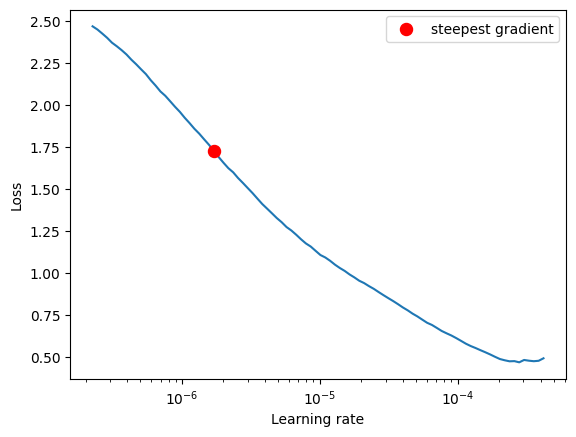


✅ Perhitungan Selesai.
Learning Rate yang disarankan (titik penurunan loss paling tajam) adalah: 0.00000170


In [ ]:
# --- Ganti seluruh blok 'if FIND_LEARNING_RATE:' di Cell 7 dengan ini ---

FIND_LEARNING_RATE = True # Ganti menjadi False setelah menemukan LR yang bagus

if FIND_LEARNING_RATE:
    # 1. Impor dan instal pustaka yang dibutuhkan
    !pip install torch-lr-finder -q
    import torch
    from torch_lr_finder import LRFinder
    import numpy as np

    print("MODE: Mencari Learning Rate Optimal...")

    # 2. Buat kelas LRFinder khusus untuk model deteksi
    # (Kode ini sudah benar, tidak perlu diubah)
    class DetectionLRFinder(LRFinder):
        def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer):
            self.model.train()
            total_loss = None
            self.optimizer.zero_grad()
            for i in range(accumulation_steps):
                try:
                    images, targets = next(train_iter)
                except StopIteration:
                    train_iter = iter(self.train_loader)
                    images, targets = next(train_iter)
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                loss = sum(l for l in loss_dict.values())
                loss /= accumulation_steps
                loss.backward()
                if total_loss is None:
                    total_loss = loss
                else:
                    total_loss += loss
            self.optimizer.step()
            return total_loss.item()

    # 3. Inisialisasi model dan optimizer
    model_finder = create_model(NUM_CLASSES).to(DEVICE)    # <-- PERBAIKAN 2: Mengubah num_classes menjadi NUM_CLASSES
    optimizer_finder = torch.optim.RMSprop(model_finder.parameters(), lr=1e-7, weight_decay=0.0005)

    # 4. Inisialisasi DataLoader
    train_dataset_finder = CustomDataset(TRAIN_IMG, TRAIN_ANNOT, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
    train_loader_finder = DataLoader(train_dataset_finder, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)

    # 5. Jalankan LR Finder
    lr_finder = DetectionLRFinder(model_finder, optimizer_finder, criterion=None, device=DEVICE)
    print("Menjalankan LR Range Test... Ini mungkin memakan beberapa menit.")
    lr_finder.range_test(train_loader_finder, end_lr=1, num_iter=200, step_mode="exp")

    # 6. Plot hasilnya
    lr_finder.plot()

    # 7. Hitung dan cetak LR yang disarankan
    lrs = lr_finder.history['lr']
    losses = lr_finder.history['loss']
    grads = np.gradient(losses)
    min_grad_idx = np.argmin(grads)
    suggested_lr = lrs[min_grad_idx]

    print(f"\n✅ Perhitungan Selesai.")
    print(f"Learning Rate yang disarankan (titik penurunan loss paling tajam) adalah: {suggested_lr:.8f}")

    lr_finder.reset()

In [ ]:
# --- Cell 7: train.py ---

# Inisialisasi datasets dan loaders
train_dataset = CustomDataset(TRAIN_IMG, TRAIN_ANNOT, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = CustomDataset(VALID_IMG, VALID_ANNOT, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
print(f"Data latih: {len(train_dataset)} | Data validasi: {len(valid_dataset)}\n")

# Inisialisasi model dan optimizer
model = create_model(NUM_CLASSES, min_size=RESIZE_TO, max_size=RESIZE_TO).to(DEVICE)
optimizer = torch.optim.RMSprop(model.parameters(), lr=suggested_lr, alpha=0.99, weight_decay=0.0005)

# Inisialisasi pelacak metrik
train_loss_hist = Averager()
map_metric = MeanAveragePrecision()
save_best_model = SaveBestModel()
metrics_data, map_50_list, map_95_list = [], [], []

# Loop Pelatihan
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS} ---")
    train_loss_hist.reset(); model.train()
    prog_bar = tqdm(train_loader, total=len(train_loader))

    # Fase Training
    for images, targets in prog_bar:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward(); optimizer.step()
        train_loss_hist.send(losses.item())
        prog_bar.set_description(f"Loss: {losses.item():.4f}")
    print(f"Loss Pelatihan: {train_loss_hist.value:.4f}")

    # Fase Validasi
    model.eval(); map_metric.reset()
    all_true_labels, all_pred_labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(valid_loader, desc="Validating"):
            images = [img.to(DEVICE) for img in images]; outputs = model(images)
            for i in range(len(images)):
                true_labels, true_boxes = targets[i]["labels"].cpu(), targets[i]["boxes"].cpu()
                pred_scores, pred_labels, pred_boxes = outputs[i]["scores"].cpu(), outputs[i]["labels"].cpu(), outputs[i]["boxes"].cpu()
                mask = pred_scores > 0.5
                map_metric.update([{"boxes": pred_boxes[mask], "scores": pred_scores[mask], "labels": pred_labels[mask]}],
                                  [{"boxes": true_boxes, "labels": true_labels}])
                all_true_labels.extend(true_labels.numpy())
                all_pred_labels.extend(pred_labels[mask].numpy())

    # Kalkulasi Metrik
    map_result = map_metric.compute()
    min_len = min(len(all_true_labels), len(all_pred_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels[:min_len], all_pred_labels[:min_len], average="weighted", zero_division=0)
    print(f"mAP@0.5: {map_result['map_50']:.4f}, mAP@0.5:0.95: {map_result['map']:.4f}, Precision: {precision:.4f}, F1: {f1:.4f}")

    # Simpan hasil
    map_50_list.append(map_result['map_50'].item()); map_95_list.append(map_result['map'].item())
    metrics_data.append({"Epoch": epoch+1, "Train Loss": train_loss_hist.value, "mAP@0.5": map_result['map_50'].item(), "mAP@0.5:0.95": map_result['map'].item(), "Precision": precision, "Recall": recall, "F1-Score": f1})
    train_losses = [e["Train Loss"] for e in metrics_data]
    save_loss_plot(OUT_DIR, train_losses); save_mAP(OUT_DIR, map_50_list, map_95_list)
    save_best_model(model, map_result['map'].item(), epoch, OUT_DIR)

# Simpan metrik ke Excel
pd.DataFrame(metrics_data).to_excel(f"{OUT_DIR}/all_metrics.xlsx", index=False)
print("\n✅ Pelatihan Selesai!")

Data latih: 1295 | Data validasi: 325



/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


✅ Model Faster R-CNN dengan backbone efficientnet_b0 berhasil dibuat (dengan AnchorGenerator yang benar).

--- Epoch 1/20 ---


Loss: 0.4402: 100%|██████████| 162/162 [00:32<00:00,  4.97it/s]


Loss Pelatihan: 0.6320


Validating: 100%|██████████| 41/41 [00:04<00:00,  9.71it/s]


mAP@0.5: 0.6100, mAP@0.5:0.95: 0.2863, Precision: 0.8367, F1: 0.8127

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.2863.pth

--- Epoch 2/20 ---


Loss: 0.3347: 100%|██████████| 162/162 [00:32<00:00,  5.06it/s]


Loss Pelatihan: 0.3760


Validating: 100%|██████████| 41/41 [00:04<00:00,  9.92it/s]


mAP@0.5: 0.7996, mAP@0.5:0.95: 0.4198, Precision: 0.7839, F1: 0.7238

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.4198.pth

--- Epoch 3/20 ---


Loss: 0.2164: 100%|██████████| 162/162 [00:31<00:00,  5.10it/s]


Loss Pelatihan: 0.2706


Validating: 100%|██████████| 41/41 [00:04<00:00,  9.91it/s]


mAP@0.5: 0.8700, mAP@0.5:0.95: 0.5246, Precision: 0.6385, F1: 0.5694

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.5246.pth

--- Epoch 4/20 ---


Loss: 0.1888: 100%|██████████| 162/162 [00:31<00:00,  5.07it/s]


Loss Pelatihan: 0.2125


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.07it/s]


mAP@0.5: 0.8964, mAP@0.5:0.95: 0.5749, Precision: 0.6847, F1: 0.6433

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.5749.pth

--- Epoch 5/20 ---


Loss: 0.1508: 100%|██████████| 162/162 [00:31<00:00,  5.12it/s]


Loss Pelatihan: 0.1808


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.06it/s]


mAP@0.5: 0.9191, mAP@0.5:0.95: 0.6073, Precision: 0.4075, F1: 0.3481

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.6073.pth

--- Epoch 6/20 ---


Loss: 0.1615: 100%|██████████| 162/162 [00:31<00:00,  5.13it/s]


Loss Pelatihan: 0.1617


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.06it/s]


mAP@0.5: 0.9255, mAP@0.5:0.95: 0.6260, Precision: 0.6688, F1: 0.6165

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.6260.pth

--- Epoch 7/20 ---


Loss: 0.1613: 100%|██████████| 162/162 [00:31<00:00,  5.14it/s]


Loss Pelatihan: 0.1476


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.16it/s]


mAP@0.5: 0.9361, mAP@0.5:0.95: 0.6630, Precision: 0.7384, F1: 0.7259

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.6630.pth

--- Epoch 8/20 ---


Loss: 0.0896: 100%|██████████| 162/162 [00:31<00:00,  5.11it/s]


Loss Pelatihan: 0.1390


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.05it/s]


mAP@0.5: 0.9384, mAP@0.5:0.95: 0.6766, Precision: 0.6537, F1: 0.6189

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.6766.pth

--- Epoch 9/20 ---


Loss: 0.1274: 100%|██████████| 162/162 [00:31<00:00,  5.08it/s]


Loss Pelatihan: 0.1310


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.07it/s]


mAP@0.5: 0.9491, mAP@0.5:0.95: 0.6754, Precision: 0.6925, F1: 0.6393

--- Epoch 10/20 ---


Loss: 0.1447: 100%|██████████| 162/162 [00:31<00:00,  5.12it/s]


Loss Pelatihan: 0.1233


Validating: 100%|██████████| 41/41 [00:04<00:00,  9.91it/s]


mAP@0.5: 0.9612, mAP@0.5:0.95: 0.6930, Precision: 0.6680, F1: 0.6367

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.6930.pth

--- Epoch 11/20 ---


Loss: 0.0986: 100%|██████████| 162/162 [00:31<00:00,  5.11it/s]


Loss Pelatihan: 0.1168


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.15it/s]


mAP@0.5: 0.9813, mAP@0.5:0.95: 0.7105, Precision: 0.7395, F1: 0.7036

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7105.pth

--- Epoch 12/20 ---


Loss: 0.1267: 100%|██████████| 162/162 [00:31<00:00,  5.14it/s]


Loss Pelatihan: 0.1114


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.04it/s]


mAP@0.5: 0.9702, mAP@0.5:0.95: 0.7124, Precision: 0.6772, F1: 0.6490

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7124.pth

--- Epoch 13/20 ---


Loss: 0.0973: 100%|██████████| 162/162 [00:31<00:00,  5.13it/s]


Loss Pelatihan: 0.1059


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.14it/s]


mAP@0.5: 0.9852, mAP@0.5:0.95: 0.7366, Precision: 0.6933, F1: 0.6439

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7366.pth

--- Epoch 14/20 ---


Loss: 0.0778: 100%|██████████| 162/162 [00:31<00:00,  5.12it/s]


Loss Pelatihan: 0.1030


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.05it/s]


mAP@0.5: 0.9641, mAP@0.5:0.95: 0.7290, Precision: 0.7592, F1: 0.7367

--- Epoch 15/20 ---


Loss: 0.0821: 100%|██████████| 162/162 [00:31<00:00,  5.13it/s]


Loss Pelatihan: 0.0994


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.09it/s]


mAP@0.5: 0.9916, mAP@0.5:0.95: 0.7537, Precision: 0.7875, F1: 0.7691

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7537.pth

--- Epoch 16/20 ---


Loss: 0.0933: 100%|██████████| 162/162 [00:31<00:00,  5.12it/s]


Loss Pelatihan: 0.0967


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.06it/s]


mAP@0.5: 0.9813, mAP@0.5:0.95: 0.7428, Precision: 0.7845, F1: 0.7685

--- Epoch 17/20 ---


Loss: 0.0979: 100%|██████████| 162/162 [00:31<00:00,  5.13it/s]


Loss Pelatihan: 0.0945


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.12it/s]


mAP@0.5: 0.9883, mAP@0.5:0.95: 0.7579, Precision: 0.8152, F1: 0.7978

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7579.pth

--- Epoch 18/20 ---


Loss: 0.0992: 100%|██████████| 162/162 [00:31<00:00,  5.10it/s]


Loss Pelatihan: 0.0908


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.09it/s]


mAP@0.5: 0.9898, mAP@0.5:0.95: 0.7649, Precision: 0.7660, F1: 0.7344

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7649.pth

--- Epoch 19/20 ---


Loss: 0.0888: 100%|██████████| 162/162 [00:31<00:00,  5.10it/s]


Loss Pelatihan: 0.0878


Validating: 100%|██████████| 41/41 [00:04<00:00,  9.96it/s]


mAP@0.5: 0.9844, mAP@0.5:0.95: 0.7663, Precision: 0.8335, F1: 0.8220

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7663.pth

--- Epoch 20/20 ---


Loss: 0.0802: 100%|██████████| 162/162 [00:31<00:00,  5.09it/s]


Loss Pelatihan: 0.0863


Validating: 100%|██████████| 41/41 [00:04<00:00, 10.01it/s]


mAP@0.5: 0.9971, mAP@0.5:0.95: 0.7800, Precision: 0.8132, F1: 0.7981

Valid mAP meningkat. Menyimpan model ke outputs/best_model_mAP_0.7800.pth

✅ Pelatihan Selesai!


In [ ]:
# --- SEL BARU: EVALUASI PADA HOLD-OUT TEST SET ---

# 1. Tentukan path ke test set Anda
#    (Anda mungkin perlu membuat folder ini dari data asli Anda)
TEST_IMG_DIR = os.path.join(OUTPUT_DIR, "val", "Image")
TEST_ANNOT_DIR = os.path.join(OUTPUT_DIR, "val", "Annotation")

# Pastikan folder ada
if not os.path.exists(TEST_IMG_DIR):
    print(f"❌ Peringatan: Direktori Test Set '{TEST_IMG_DIR}' tidak ditemukan. Lewati evaluasi.")
else:
    print("Memulai evaluasi pada Test Set...")

    # 2. Muat model terbaik yang sudah dilatih
    # Temukan path model terbaik secara otomatis dari folder outputs
    try:
        best_model_path = sorted(glob.glob(f"{OUT_DIR}/best_model_*.pth"))[-1]
        print(f"Memuat model dari: {best_model_path}")
    except IndexError:
        print("❌ Tidak dapat menemukan model 'best_model.pth'. Pastikan pelatihan sudah selesai.")
        best_model_path = None

    if best_model_path:
        model_test = create_model(NUM_CLASSES).to(DEVICE)
        checkpoint = torch.load(best_model_path, map_location=DEVICE)
        model_test.load_state_dict(checkpoint['model_state_dict'])
        model_test.eval() # Set model ke mode evaluasi

        # 3. Buat DataLoader untuk test set
        test_dataset = CustomDataset(TEST_IMG_DIR, TEST_ANNOT_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

        # 4. Inisialisasi metrik dan jalankan evaluasi
        map_metric_test = MeanAveragePrecision()
        with torch.no_grad():
            for images, targets in tqdm(test_loader, desc="Testing"):
                images = [img.to(DEVICE) for img in images]
                outputs = model_test(images)

                # Pindahkan output ke CPU untuk evaluasi
                targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
                outputs_cpu = [{k: v.cpu() for k, v in t.items()} for t in outputs]

                map_metric_test.update(outputs_cpu, targets_cpu)

        # 5. Hitung dan tampilkan hasil akhir
        test_results = map_metric_test.compute()
        print("\n--- HASIL PADA TEST SET ---")
        print(f"mAP@0.5: {test_results['map_50']:.4f}")
        print(f"mAP@0.5:0.95: {test_results['map']:.4f}")
        print(f"mAP (Large Objects): {test_results['map_large']:.4f}")

Memulai evaluasi pada Test Set...
Memuat model dari: outputs/best_model_mAP_0.7800.pth
✅ Model Faster R-CNN dengan backbone efficientnet_b0 berhasil dibuat (dengan AnchorGenerator yang benar).


/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Testing: 100%|██████████| 41/41 [00:04<00:00,  9.93it/s]



--- HASIL PADA TEST SET ---
mAP@0.5: 0.9971
mAP@0.5:0.95: 0.7805
mAP (Large Objects): 0.7810
